In [78]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.mse = []

    def on_batch_end(self, batch, logs={}):
        self.mse.append(logs.get('mean_squared_error'))
        


input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error', metrics=['accuracy','mse'])
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()
x_train = np.concatenate((x_train,x_train),axis=0)
x_train_noisy = x_train
x_test_noisy = x_test
for index,row in enumerate(x_train_noisy):
    random_mask = np.random.rand(1,784)
    np.putmask(row,random_mask<0.03,255-row )
    
for index,row in enumerate(x_test_noisy):
    random_mask = np.random.rand(1,784)
    np.putmask(row,random_mask<0.03,255-row )
    
    
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train_noisy = x_train_noisy.astype('float32') / 255.
x_test_noisy = x_test_noisy.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
x_train_noisy = np.reshape(x_train_noisy, (len(x_train_noisy), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test_noisy = np.reshape(x_test_noisy, (len(x_test_noisy), 28, 28, 1))
no_of_epochs = 5
from keras.callbacks import TensorBoard
history = LossHistory()
autoencoder.fit(x_train_noisy, x_train,
                epochs=no_of_epochs,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[history])

decoded_imgs = autoencoder.predict(x_test_noisy)


print history.mse



Train on 120000 samples, validate on 10000 samples
Epoch 1/5
120000/120000 [==============================] - 15s - loss: 0.0749 - acc: 0.7651 - mean_squared_error: 0.0749 - val_loss: 0.0580 - val_acc: 0.7714 - val_mean_squared_error: 0.0580

<type 'tuple'>


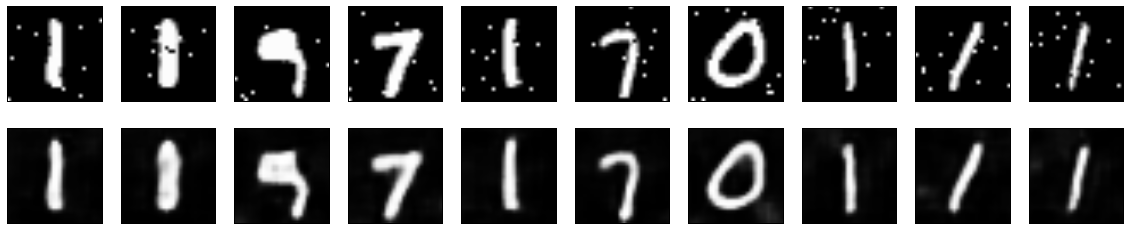

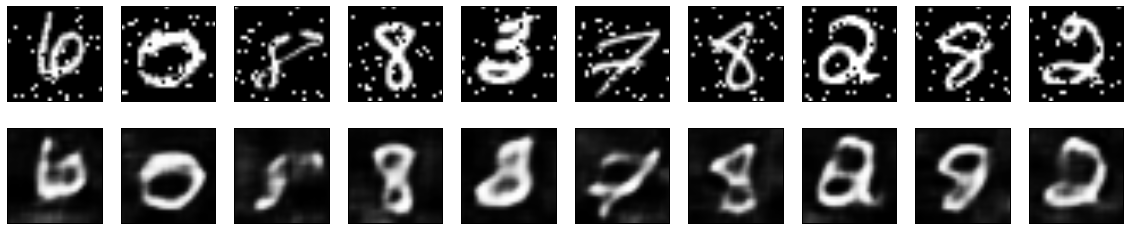

In [55]:
from operator import itemgetter
x_test_noisy_copy = x_test_noisy.astype('float32') * 255.
decoded_imgs_copy = decoded_imgs.astype('float32') * 255.
# distance = np.linalg.norm(x_test_noisy_copy-decoded_imgs_copy)
dist = []
for index,image in enumerate(x_test_noisy_copy):
    distance = np.linalg.norm(x_test_noisy_copy[index]-decoded_imgs_copy[index])
    val = (index,distance)
    dist.append(val)
print type(dist[0])
sorted_dist = sorted(dist,key = itemgetter(1))
best_10 = [index_dist[0] for index_dist in sorted_dist[:10]]
worst_10 = [index_dist[0] for index_dist in sorted_dist[-10:]]
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
plt.title('Best 10 images')
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy_copy[best_10[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[best_10[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

import matplotlib.pyplot as plt
%matplotlib inline
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
plt.title('Worst 10 images')
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy_copy[worst_10[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[worst_10[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

printing plot


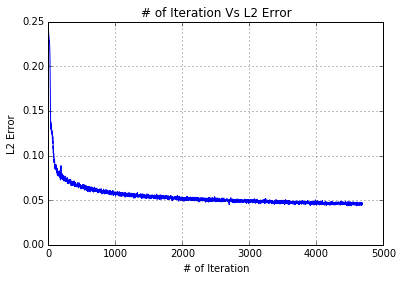

In [82]:
print 'printing plot'
mse_per_epoch = []
width = len(history.mse)/no_of_epochs
start = 0
epoch_n = no_of_epochs
while epoch_n >0:
    per_epoch_mse = history.mse[start:start+width]
    start = start + width
    epoch_n -= 1
    sum_mse = sum(per_epoch_mse)/len(per_epoch_mse)
    mse_per_epoch.append(sum_mse)

# plt.plot(range(no_of_epochs), mse_per_epoch)
plt.plot(range(len(history.mse)), history.mse)

plt.xlabel('# of Iteration')
plt.ylabel('L2 Error')
plt.title('# of Iteration Vs L2 Error')
plt.grid(True)
plt.show()
    


In [119]:
# model1.add(Convolution2D(32, 5, 5, border_mode='valid', input_shape=(1, 28, 28))) 
# model1.add(Activation("relu"))
# model1.add(MaxPooling2D(pool_size=(2, 2)))
# model1.add(Flatten())
# model1.add(Dense(num_classes))
# model1.add(Activation("softmax"))
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.mse = []

    def on_batch_end(self, batch, logs={}):
        self.mse.append(logs.get('mean_squared_error'))

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='sigmoid', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='sigmoid', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='sigmoid')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_1 = Model(input_img, decoded)
autoencoder_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy','mse'])

history = LossHistory()

autoencoder_1.fit(x_train_noisy, x_train,
                epochs=no_of_epochs,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[history])
decoded_imgs = autoencoder_1.predict(x_test_noisy)


print history.mse

Train on 120000 samples, validate on 10000 samples
Epoch 1/5
120000/120000 [==============================] - 18s - loss: 0.0794 - acc: 0.7748 - mean_squared_error: 0.0794 - val_loss: 0.0671 - val_acc: 0.7719 - val_mean_squared_error: 0.0671

[[[[ 18.10637283]
   [  8.42141247]
   [  8.42084885]
   ..., 
   [  8.42060947]
   [  8.42061806]
   [ 10.66186142]]

  [[  8.7058897 ]
   [  6.73100138]
   [  6.73144913]
   ..., 
   [  6.74434805]
   [  6.74465561]
   [ 10.93190193]]

  [[  8.71129799]
   [  6.73131752]
   [  6.73074532]
   ..., 
   [  6.76819944]
   [  6.77887487]
   [ 10.92944241]]

  ..., 
  [[  8.70185661]
   [  6.72665024]
   [  6.72833061]
   ..., 
   [  6.73089075]
   [  6.73088837]
   [ 10.92525578]]

  [[  8.69890976]
   [  6.7269454 ]
   [  6.72933197]
   ..., 
   [  6.73089075]
   [  6.73088837]
   [ 10.92525387]]

  [[ 12.32796288]
   [ 10.00042534]
   [ 10.00060558]
   ..., 
   [ 10.00105476]
   [ 10.00105476]
   [ 19.52959442]]]


 [[[ 18.10492134]
   [  8.42137909]
   [  8.42112637]
   ..., 
   [ 14.14859581]
   [ 14.80590439]
   [ 11.04019833]]

  [[  8.70718479]
   [  6.73160315]
   [  6.73205996]
   ..., 
   [  5.87392187]
   [  5.37894487]
   [  5.68741417]]

  [[  8.71698856]
   [  6.73143005]
  

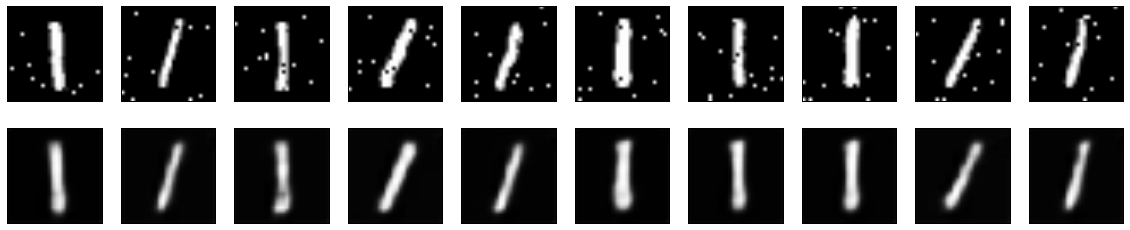

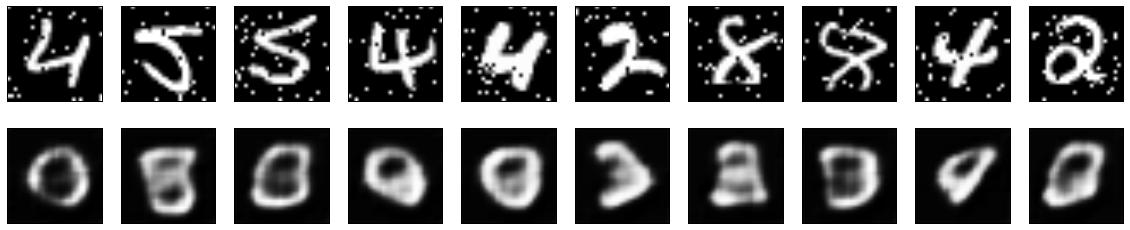

In [120]:
from operator import itemgetter
x_test_noisy_copy = x_test_noisy.astype('float32') * 255.
decoded_imgs_copy = decoded_imgs.astype('float32') * 255.
dist = []
for index,image in enumerate(x_test_noisy_copy):
    distance = np.linalg.norm(x_test_noisy_copy[index]-decoded_imgs_copy[index])
    val = (index,distance)
    dist.append(val)

print decoded_imgs_copy    
    
sorted_dist = sorted(dist,key = itemgetter(1))
best_10 = [index_dist[0] for index_dist in sorted_dist[:10]]
worst_10 = [index_dist[0] for index_dist in sorted_dist[-10:]]
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
plt.title('Best 10 images')
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy_copy[best_10[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_copy[best_10[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

import matplotlib.pyplot as plt
%matplotlib inline
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
plt.title('Worst 10 images')
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy_copy[worst_10[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_copy[worst_10[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

printing plot


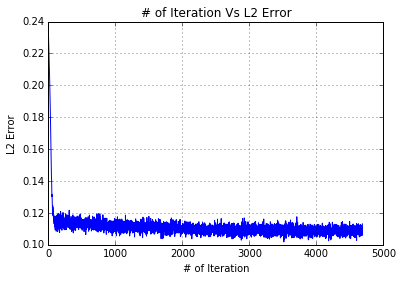

In [101]:
print 'printing plot'
mse_per_epoch = []
width = len(history.mse)/no_of_epochs
start = 0
epoch_n = no_of_epochs
while epoch_n >0:
    per_epoch_mse = history.mse[start:start+width]
    start = start + width
    epoch_n -= 1
    sum_mse = sum(per_epoch_mse)/len(per_epoch_mse)
    mse_per_epoch.append(sum_mse)

# plt.plot(range(no_of_epochs), mse_per_epoch)
plt.plot(range(len(history.mse)), history.mse)

plt.xlabel('# of Iteration')
plt.ylabel('L2 Error')
plt.title('# of Iteration Vs L2 Error')
plt.grid(True)
plt.show()

In [113]:
from keras.layers import Flatten
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.mse = []

    def on_batch_end(self, batch, logs={}):
        self.mse.append(logs.get('mean_squared_error'))

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error', metrics=['accuracy','mse'])

# autoencoder_1 = Model(input_img, decoded)
# autoencoder_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy','mse'])

history = LossHistory()

autoencoder.fit(x_train_noisy, x_train,
                epochs=no_of_epochs,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[history])
decoded_imgs = autoencoder.predict(x_test_noisy)


print history.mse

Train on 120000 samples, validate on 10000 samples
Epoch 1/5
120000/120000 [==============================] - 18s - loss: 0.0860 - acc: 0.7758 - mean_squared_error: 0.0860 - val_loss: 0.0783 - val_acc: 0.7811 - val_mean_squared_error: 0.0783

[[[[  2.25204716e+01]
   [  3.80120111e+00]
   [  6.87091231e-01]
   ..., 
   [  1.96436501e+00]
   [  1.53912222e+00]
   [  1.26202929e+00]]

  [[  3.89407730e+00]
   [  4.09606129e-01]
   [  2.40430553e-02]
   ..., 
   [  1.54275641e-01]
   [  1.18661620e-01]
   [  2.76503265e-01]]

  [[  3.18172383e+00]
   [  3.31653625e-01]
   [  2.69573182e-02]
   ..., 
   [  2.78854936e-01]
   [  2.12192193e-01]
   [  4.00033802e-01]]

  ..., 
  [[  8.24030304e+00]
   [  3.81526136e+00]
   [  6.14411116e+00]
   ..., 
   [  3.31804082e-02]
   [  1.59162637e-02]
   [  5.40316403e-02]]

  [[  1.08082628e+01]
   [  4.60931492e+00]
   [  6.65893459e+00]
   ..., 
   [  8.65631998e-02]
   [  4.72083837e-02]
   [  1.89358532e-01]]

  [[  2.01905556e+01]
   [  7.63739157e+00]
   [  8.60111904e+00]
   ..., 
   [  5.95925570e-01]
   [  3.75651509e-01]
   [  1.10399508e+00]]]


 [[[  2.15554066e+01]
   [  4.07431650e+00]
   [  1.85339057e+00]
   ..., 
   [  1.43025396e-02]
   [  9.58252326e-03]
   [  5.29455

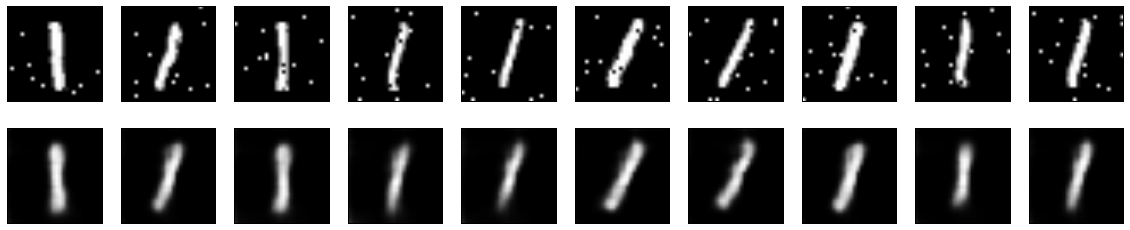

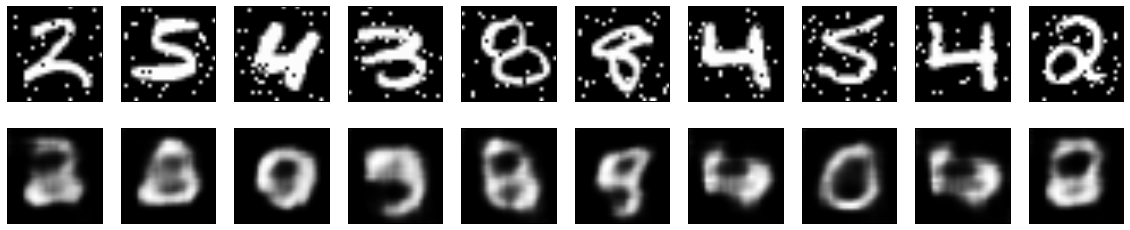

In [114]:

from operator import itemgetter
x_test_noisy_copy = x_test_noisy.astype('float32') * 255.
decoded_imgs_copy = decoded_imgs.astype('float32') * 255.
dist = []
for index,image in enumerate(x_test_noisy_copy):
    distance = np.linalg.norm(x_test_noisy_copy[index]-decoded_imgs_copy[index])
    val = (index,distance)
    dist.append(val)

print decoded_imgs_copy    
    
sorted_dist = sorted(dist,key = itemgetter(1))
best_10 = [index_dist[0] for index_dist in sorted_dist[:10]]
worst_10 = [index_dist[0] for index_dist in sorted_dist[-10:]]
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
plt.title('Best 10 images')
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy_copy[best_10[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_copy[best_10[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

import matplotlib.pyplot as plt
%matplotlib inline
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
plt.title('Worst 10 images')
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy_copy[worst_10[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_copy[worst_10[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

printing plot


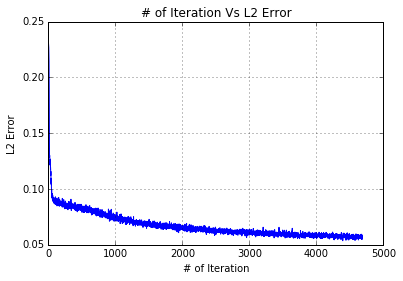

In [115]:
print 'printing plot'
mse_per_epoch = []
width = len(history.mse)/no_of_epochs
start = 0
epoch_n = no_of_epochs
while epoch_n >0:
    per_epoch_mse = history.mse[start:start+width]
    start = start + width
    epoch_n -= 1
    sum_mse = sum(per_epoch_mse)/len(per_epoch_mse)
    mse_per_epoch.append(sum_mse)

# plt.plot(range(no_of_epochs), mse_per_epoch)
plt.plot(range(len(history.mse)), history.mse)

plt.xlabel('# of Iteration')
plt.ylabel('L2 Error')
plt.title('# of Iteration Vs L2 Error')
plt.grid(True)
plt.show()

In [116]:
from keras.layers import Flatten
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.mse = []

    def on_batch_end(self, batch, logs={}):
        self.mse.append(logs.get('mean_squared_error'))

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error', metrics=['accuracy','mse'])

# autoencoder_1 = Model(input_img, decoded)
# autoencoder_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy','mse'])

history = LossHistory()

autoencoder.fit(x_train_noisy, x_train,
                epochs=no_of_epochs,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[history])
decoded_imgs = autoencoder.predict(x_test_noisy)


print history.mse

Train on 120000 samples, validate on 10000 samples
Epoch 1/5
120000/120000 [==============================] - 31s - loss: 0.0815 - acc: 0.7756 - mean_squared_error: 0.0815 - val_loss: 0.0691 - val_acc: 0.7730 - val_mean_squared_error: 0.0691

[[[[  1.24863033e+01]
   [  3.92713141e+00]
   [  2.95703173e+00]
   ..., 
   [  6.21675587e+00]
   [  9.38958645e+00]
   [  2.03864899e+01]]

  [[  4.17584229e+00]
   [  1.08470547e+00]
   [  7.58191228e-01]
   ..., 
   [  1.93017864e+00]
   [  4.64865398e+00]
   [  9.95542908e+00]]

  [[  5.02419662e+00]
   [  1.38027346e+00]
   [  8.97523999e-01]
   ..., 
   [  6.79412603e-01]
   [  1.69532335e+00]
   [  4.33705664e+00]]

  ..., 
  [[  2.83977342e+00]
   [  1.25071466e+00]
   [  1.13672912e+00]
   ..., 
   [  1.75280508e-03]
   [  1.19419685e-02]
   [  6.44251406e-02]]

  [[  1.92314517e+00]
   [  5.67157924e-01]
   [  4.13682103e-01]
   ..., 
   [  1.07261830e-03]
   [  3.66277434e-03]
   [  2.63040029e-02]]

  [[  3.26820350e+00]
   [  1.03573930e+00]
   [  8.77810001e-01]
   ..., 
   [  1.18519766e-02]
   [  3.05863488e-02]
   [  3.87659669e-01]]]


 [[[  6.27940989e+00]
   [  2.12178922e+00]
   [  1.88200533e+00]
   ..., 
   [  5.94916487e+00]
   [  7.45232058e+00]
   [  1.16320

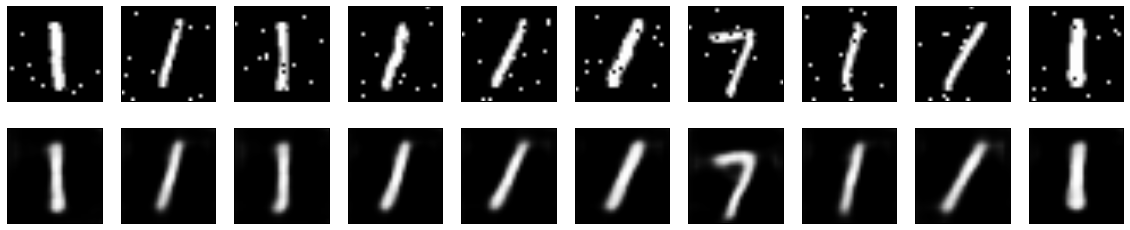

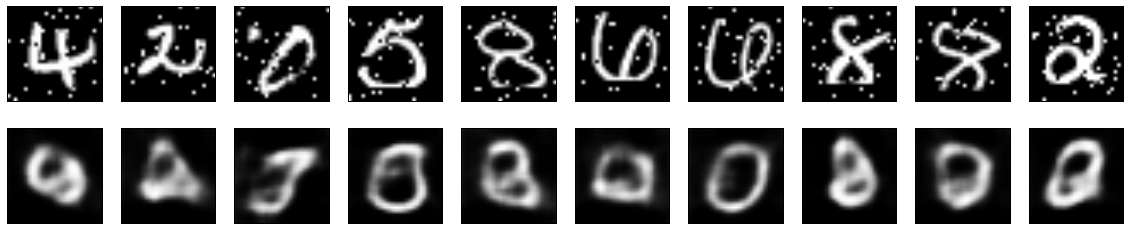

In [117]:
from operator import itemgetter
x_test_noisy_copy = x_test_noisy.astype('float32') * 255.
decoded_imgs_copy = decoded_imgs.astype('float32') * 255.
dist = []
for index,image in enumerate(x_test_noisy_copy):
    distance = np.linalg.norm(x_test_noisy_copy[index]-decoded_imgs_copy[index])
    val = (index,distance)
    dist.append(val)

print decoded_imgs_copy    
    
sorted_dist = sorted(dist,key = itemgetter(1))
best_10 = [index_dist[0] for index_dist in sorted_dist[:10]]
worst_10 = [index_dist[0] for index_dist in sorted_dist[-10:]]
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
plt.title('Best 10 images')
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy_copy[best_10[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_copy[best_10[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

import matplotlib.pyplot as plt
%matplotlib inline
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
plt.title('Worst 10 images')
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy_copy[worst_10[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_copy[worst_10[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

printing plot


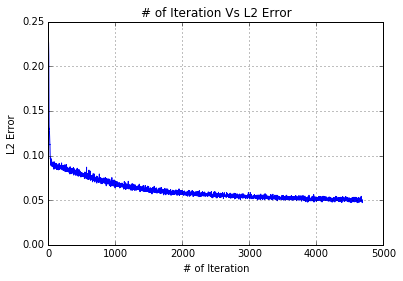

In [118]:
print 'printing plot'
mse_per_epoch = []
width = len(history.mse)/no_of_epochs
start = 0
epoch_n = no_of_epochs
while epoch_n >0:
    per_epoch_mse = history.mse[start:start+width]
    start = start + width
    epoch_n -= 1
    sum_mse = sum(per_epoch_mse)/len(per_epoch_mse)
    mse_per_epoch.append(sum_mse)

# plt.plot(range(no_of_epochs), mse_per_epoch)
plt.plot(range(len(history.mse)), history.mse)

plt.xlabel('# of Iteration')
plt.ylabel('L2 Error')
plt.title('# of Iteration Vs L2 Error')
plt.grid(True)
plt.show()

In [ ]:
#Have tried adding more layers to cnn, changing optimizers, activation and loss parameter to check which convolution network gives best results